# Imports

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import pandas as pd       
import os 
import math 
import seaborn as sns
sns.set()
import plotly.express as px
import scipy
import numpy as np
import random
import matplotlib.pyplot as plt  
import IPython.display as ipd  # To play sound in the notebook
import librosa
import librosa.display
import os
import datetime
from time import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_extraction.image import extract_patches_2d
from sklearn.manifold import TSNE
import tensorflow as tf
from keras.utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import TimeDistributed, LSTM
from keras.layers import SpatialDropout1D, MaxPool1D, Conv1D, GlobalMaxPool1D
from keras.optimizers import SGD, Adam

# Working path
path = "/content/drive/My Drive/DLAS/data/speech-accent-archive"
os.chdir(path)
print(os.listdir())

# Consistent Seeding
SEED = 11
os.environ['PYTHONHASHSEED']= str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


['recordings', 'reading-passage.txt', 'speakers_all.csv', 'speaker_info_final.csv', 'model.png', 'results']


Using TensorFlow backend.


In [0]:
! cp -r /content/drive/My\ Drive/DLAS/data/recordings_wav.zip /home/
! unzip /home/recordings_wav.zip -d /home/

Archive:  /home/recordings_wav.zip
   creating: /home/recordings_wav/
  inflating: /home/recordings_wav/afrikaans1.wav  
  inflating: /home/recordings_wav/afrikaans2.wav  
  inflating: /home/recordings_wav/afrikaans3.wav  
  inflating: /home/recordings_wav/afrikaans4.wav  
  inflating: /home/recordings_wav/afrikaans5.wav  
  inflating: /home/recordings_wav/agni1.wav  
  inflating: /home/recordings_wav/akan1.wav  
  inflating: /home/recordings_wav/albanian1.wav  
  inflating: /home/recordings_wav/albanian2.wav  
  inflating: /home/recordings_wav/albanian3.wav  
  inflating: /home/recordings_wav/albanian4.wav  
  inflating: /home/recordings_wav/albanian5.wav  
  inflating: /home/recordings_wav/albanian6.wav  
  inflating: /home/recordings_wav/albanian7.wav  
  inflating: /home/recordings_wav/albanian8.wav  
  inflating: /home/recordings_wav/albanian9.wav  
  inflating: /home/recordings_wav/amazigh1.wav  
  inflating: /home/recordings_wav/amazigh2.wav  
  inflating: /home/recordings_wav/a

# Hiperparameters

In [0]:
# Input abd target
INPUT_MODE = "embeddings" # embeddings or features
FEATURE_EXTRACTION = None #"log-mel" # None mfcc log-mel chroma
LABEL = "age_range" # sex age_range native_language native?

# Splitting and scaling
SCALING = None #"min-max"
MIN_SAMPLES_PER_CATEGORY = 50
TEST_SPLIT = 0.1
VAL_SPLIT = 0.2

# Training
OPTIMIZER = Adam(lr=0.0001) #SGD(lr=0.0001, decay=1e-6, momentum=0.9, nesterov=True)
LOSS = 'categorical_crossentropy'
EPOCHS = 150
BATCH_SIZE = 32  
CLASS_WEIGHT = {0:0.335, 1:0.301, 2:1} #{0:0.51, 1:0.09, 2:0.83, 3:1, 4:0.8, 5:0.32}
VERBOSE = 2 # 0 = silent, 1 = progress bar, 2 = one line per epoch

# Paths
DATA_PATH = "/home/recordings_wav/"
EMBEDDING_PATH = 'recordings/audio_embeddings_hop_0.1_dur_5_offset_5.npy'

# Audio Processing
SAMPLE_RATE = 16000
SAMPLES_PER_AUDIO = 200000 # 100.000 ~ 6 seconds
N_MFCC = 20
N_MELS = 128

# Functions

In [0]:
def CNN_model(input_shape, output_shape):

  model = Sequential()

  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape)) 
  model.add(Conv2D(16, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))

  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(rate=0.25))
  model.add(Dense(output_shape, activation='softmax'))

  return model

In [0]:
"""
Chroma
  model.add(Conv2D(32, (1, 4), activation='relu', input_shape=input_shape))
  model.add(Conv2D(32, (1, 4), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))

  model.add(Conv2D(32, (1, 4), activation='relu'))
  model.add(Conv2D(32, (1, 4), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))

  model.add(Conv2D(64, (1, 4), activation='relu'))
  model.add(Conv2D(64, (1, 4), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))

Log-mel
  model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))

  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))

mfcc
  model.add(Conv2D(16, (3, 3), activation='relu', input_shape=input_shape)) 
  model.add(Conv2D(16, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))

  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(Conv2D(32, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))

embeddings
  model.add(Conv2D(16, (3, 4), activation='relu', input_shape=input_shape)) 
  model.add(Conv2D(16, (3, 4), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))

  model.add(Conv2D(32, (3, 4), activation='relu'))
  model.add(Conv2D(32, (3, 4), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(rate=0.25))

all CNN models
  model.add(Flatten())
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(rate=0.25))
  model.add(Dense(output_shape, activation='softmax'))

raw
  model.add(Conv1D(16, 32, padding='same', activation='relu', input_shape=input_shape))
  model.add(BatchNormalization())
  model.add(SpatialDropout1D(0.25))
  model.add(MaxPool1D(4, 4))

  model.add(Conv1D(32, 3, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(SpatialDropout1D(0.25))
  model.add(MaxPool1D())

  model.add(Conv1D(48, 3, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(SpatialDropout1D(0.25))
  model.add(MaxPool1D())

  model.add(Conv1D(64, 3, padding='same', activation='relu'))
  model.add(BatchNormalization())
  model.add(SpatialDropout1D(0.25))
  model.add(MaxPool1D())

  model.add(Flatten())
  model.add(Dense(16, activation='relu'))
  model.add(Dropout(rate=0.25))
  model.add(Dense(output_shape, activation='softmax'))
"""
print()

In [0]:
def get_audio_features():

  X = []
  start_time = time()
  max_nb_bit = float(2 ** (16 - 1))

  for i, audio_file in enumerate(sorted(os.listdir(DATA_PATH))):

    _, x_raw = scipy.io.wavfile.read(DATA_PATH+audio_file)
    x_raw = x_raw[:SAMPLES_PER_AUDIO]
    x = x_raw / (max_nb_bit - 1.0)

    if FEATURE_EXTRACTION == "mfcc":
      x_proccessed = librosa.feature.mfcc(y=x, sr=SAMPLE_RATE, n_mfcc=N_MFCC)
    elif FEATURE_EXTRACTION == "log-mel":
      x_melspec = librosa.feature.melspectrogram(x, sr=SAMPLE_RATE, n_mels=N_MELS)
      x_proccessed = librosa.amplitude_to_db(x_melspec)
    elif FEATURE_EXTRACTION == "chroma":
      x_proccessed = librosa.feature.chroma_cqt(y=x, sr=SAMPLE_RATE)
    else:
      x_proccessed = x.copy()
    X.append(x_proccessed)
    
    if i%100==0:
      print(i, audio_file, time()-start_time)
  
  X = np.array(X)

  return X

# Main Code

In [0]:
# Checking if embeddings order is equal to csv info order (to get labels correctly)
speakers_info = pd.read_csv('speaker_info_final.csv')
speakers_info['sex'] = speakers_info['sex'].replace({'famale':'female'})

bins = [0, 28, np.inf] #[0, 25, 50, np.inf]
names = ['0-28', '28+'] #['0-30', '30-50', '50+']
speakers_info['age_range'] = pd.cut(speakers_info['age'], bins, labels=names)

speakers_info["native?"] = speakers_info["native_language"] == "english"

speakers_info = speakers_info.sort_values('file_name')
speakers_info["filename_wav"] = speakers_info["file_name"].apply(lambda x: x.split(".")[0]+".wav")
wav_files_from_df = speakers_info["filename_wav"].tolist()

wav_files_from_drive = list(sorted(os.listdir("recordings/recordings_wav")))

print("Same order?", wav_files_from_df == wav_files_from_drive)
ipd.display(speakers_info[LABEL].value_counts().to_frame().head(6))
speakers_info.head()

Same order? True


,age_range
0-28,1070
28+,1064


,age,age_onset,birthplace,native_language,sex,country,file_name,age_range,native?,filename_wav
0,27.0,9.0,"virginia, south africa",afrikaans,female,south africa,afrikaans1.mp3,0-28,False,afrikaans1.wav
1,40.0,5.0,"pretoria, south africa",afrikaans,male,south africa,afrikaans2.mp3,28+,False,afrikaans2.wav
2,43.0,4.0,"pretoria, transvaal, south africa",afrikaans,male,south africa,afrikaans3.mp3,28+,False,afrikaans3.wav
3,26.0,8.0,"pretoria, south africa",afrikaans,male,south africa,afrikaans4.mp3,0-28,False,afrikaans4.wav
4,19.0,6.0,"cape town, south africa",afrikaans,male,south africa,afrikaans5.mp3,0-28,False,afrikaans5.wav


In [0]:
df_categories = speakers_info.groupby(LABEL).apply(len)
sliced_categories = df_categories.loc[df_categories>=MIN_SAMPLES_PER_CATEGORY].index.to_list()

categories_indeces = {"train_cat": [], "val_cat": [], "test_cat": []}
for cat in sliced_categories:
  cat_indeces = speakers_info.loc[speakers_info[LABEL]==cat].index.to_list()
  np.random.shuffle(cat_indeces)
  len_train = int(len(cat_indeces) * (1-TEST_SPLIT-VAL_SPLIT))
  len_val = int(len(cat_indeces) * VAL_SPLIT)
  len_test = int(len(cat_indeces) * TEST_SPLIT)
  #print(len(cat_indeces), cat_indeces[:len_train], cat_indeces[len_train:len_train+len_val], cat_indeces[-len_test:])
  categories_indeces["train_cat"].extend(cat_indeces[:len_train])
  categories_indeces["val_cat"].extend(cat_indeces[len_train:len_train+len_val])
  categories_indeces["test_cat"].extend(cat_indeces[-len_test:])

In [0]:
# Loading embeddings and getting labels
if INPUT_MODE == "embeddings":
  X = np.load(EMBEDDING_PATH)
elif INPUT_MODE == "features":
  X = get_audio_features()

In [0]:
if SCALING == "minmax":
  X = (X - X.min()) / (X.max() - X.min())
if SCALING == "standard":
  X = (X - X.mean()) / (X.std() + np.finfo(np.float32).eps)

X = np.expand_dims(X, axis=-1)
X.shape

(2138, 41, 128, 1)

In [0]:
X_train = X[categories_indeces["train_cat"]]
X_val = X[categories_indeces["val_cat"]]
X_test = X[categories_indeces["test_cat"]]

le = LabelEncoder()
le.fit(sliced_categories)
y = speakers_info[LABEL].values

y_train = to_categorical(le.transform(y[categories_indeces["train_cat"]]))
y_val = to_categorical(le.transform(y[categories_indeces["val_cat"]]))
y_test = to_categorical(le.transform(y[categories_indeces["test_cat"]]))

print("full shape:", X.shape, y.shape)
print("train shape:", X_train.shape, y_train.shape)
print("val shape:", X_val.shape, y_val.shape)
print("test shape:", X_test.shape, y_test.shape)
print("y classes:", le.classes_)

full shape: (2138, 41, 128, 1) (2138,)
train shape: (1493, 41, 128, 1) (1493, 2)
val shape: (426, 41, 128, 1) (426, 2)
test shape: (213, 41, 128, 1) (213, 2)
y classes: ['0-28' '28+']


In [0]:
model = CNN_model(X_train.shape[1:], y_train.shape[1])
model.compile(loss=LOSS, optimizer=OPTIMIZER, metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 39, 126, 16)       160       
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 37, 124, 16)       2320      
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 18, 62, 16)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 18, 62, 16)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 16, 60, 32)        4640      
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 14, 58, 32)        9248      
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 7, 29, 32)        

In [0]:
start = time()
model_history = model.fit(X_train, y_train, 
                          epochs=10, 
                          batch_size=BATCH_SIZE, 
                          shuffle=True, 
                          validation_data=(X_val, y_val),
                          verbose=VERBOSE,
                          class_weight=CLASS_WEIGHT
                         ).history
print("{} epochs, {} time".format(EPOCHS, datetime.timedelta(seconds=time()-start)))

Train on 1493 samples, validate on 426 samples
Epoch 1/10
 - 1s - loss: 0.2140 - accuracy: 0.5713 - val_loss: 0.6464 - val_accuracy: 0.6268
Epoch 2/10
 - 1s - loss: 0.1978 - accuracy: 0.6591 - val_loss: 0.6195 - val_accuracy: 0.6808
Epoch 3/10
 - 1s - loss: 0.1927 - accuracy: 0.6604 - val_loss: 0.6100 - val_accuracy: 0.6784
Epoch 4/10
 - 1s - loss: 0.1886 - accuracy: 0.6805 - val_loss: 0.6070 - val_accuracy: 0.6831
Epoch 5/10
 - 1s - loss: 0.1856 - accuracy: 0.6939 - val_loss: 0.6056 - val_accuracy: 0.6784
Epoch 6/10
 - 1s - loss: 0.1858 - accuracy: 0.6939 - val_loss: 0.6012 - val_accuracy: 0.6878
Epoch 7/10
 - 1s - loss: 0.1833 - accuracy: 0.6973 - val_loss: 0.6012 - val_accuracy: 0.6901
Epoch 8/10
 - 1s - loss: 0.1805 - accuracy: 0.7033 - val_loss: 0.6003 - val_accuracy: 0.6901
Epoch 9/10
 - 1s - loss: 0.1814 - accuracy: 0.6999 - val_loss: 0.5984 - val_accuracy: 0.6831
Epoch 10/10
 - 1s - loss: 0.1790 - accuracy: 0.7053 - val_loss: 0.6062 - val_accuracy: 0.6925
150 epochs, 0:00:06.45

# Results

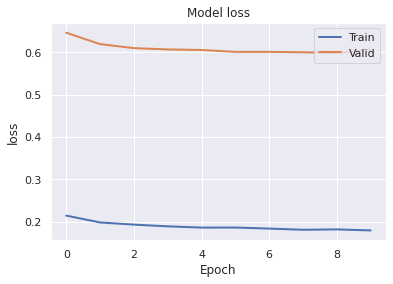

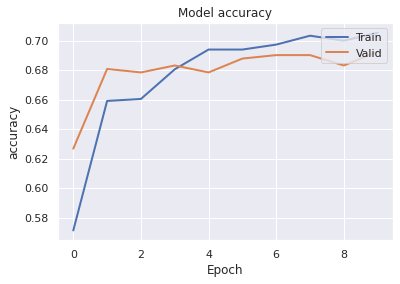

In [0]:
# Ploting loss and acurracy for both train and validation
for graph in ['loss', 'accuracy']:
    plt.plot(model_history[graph], linewidth=2, label='Train')
    plt.plot(model_history['val_'+graph], linewidth=2, label='Valid')
    plt.legend(loc='upper right')
    plt.title('Model '+graph)
    plt.ylabel(graph)
    plt.xlabel('Epoch')
    plt.show()

              precision    recall  f1-score   support

           0       0.63      0.78      0.70       107
           1       0.71      0.55      0.62       106

    accuracy                           0.66       213
   macro avg       0.67      0.66      0.66       213
weighted avg       0.67      0.66      0.66       213



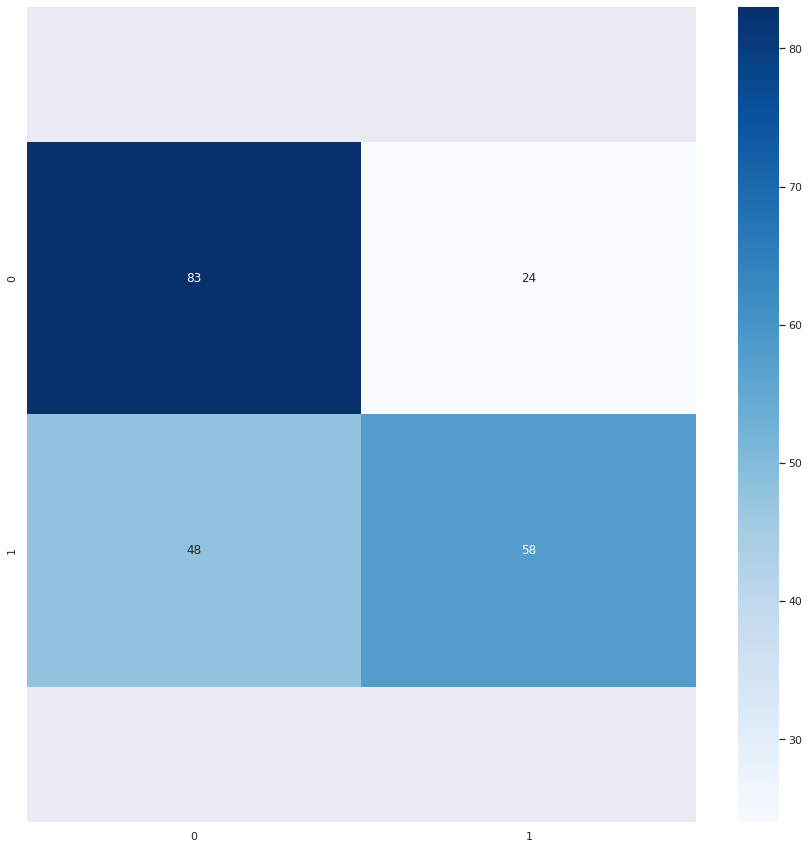

In [0]:
# Predicting with the model
y_pred = model.predict(X_test, batch_size=BATCH_SIZE)
y_pred_max = np.argmax(y_pred, axis=1)

#y_pred_max = np.zeros(shape=y_test_max.shape)
#y_pred_max.fill(1)

y_test_max = np.argmax(y_test, axis=1)
print(classification_report(y_test_max, y_pred_max))

plt.figure(figsize=(15,15))
hm = sns.heatmap(confusion_matrix(y_test_max, y_pred_max), annot=True, cmap="Blues", fmt='d')# font size
bottom, top = hm.get_ylim()
hm.set_ylim(bottom + 0.5, top - 0.5)
plt.show()

In [0]:
#print(model.layers)
layer_index = -3
embedding_model = Model(inputs=model.input,
                        outputs=model.get_layer(index=layer_index).output)
embedding_output = embedding_model.predict(X_test)
scaler = StandardScaler()
embedding_output = scaler.fit_transform(embedding_output)
embedding_output.shape

(213, 64)

In [0]:
#X_pca = X.reshape(X.shape[0],X.shape[1],X.shape[2])
#embedding_output = X_pca.mean(axis=1)
#embedding_output = X.reshape(X.shape[0],X.shape[1]*X.shape[2])
#embedding_output.shape

Number of components: 3
Explained variation per principal component:
[0.5518972  0.17389344 0.07859743]


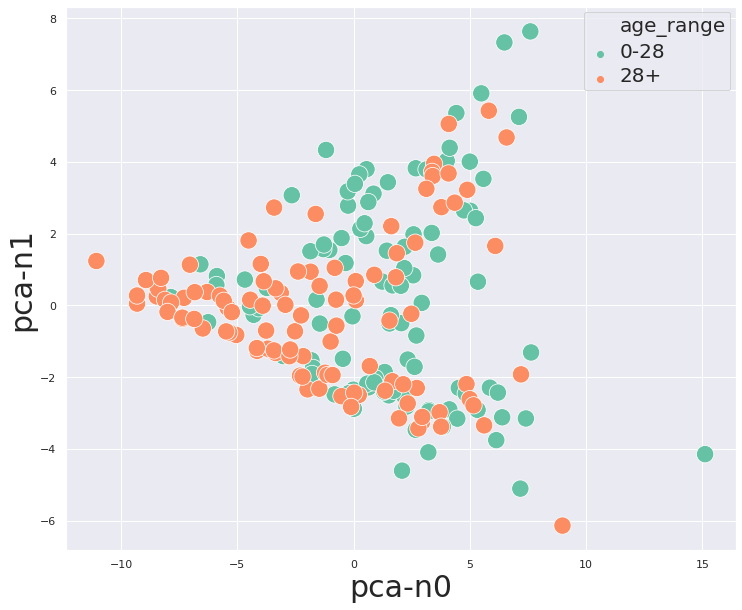

In [0]:
PLOT_LABEL = LABEL
STRATEGY = "pca"

### t-SNE ###
if STRATEGY == "tSNE":
  tsne = TSNE(n_components=3, verbose=1, perplexity=20, n_iter=300)
  data_3D = tsne.fit_transform(embedding_output)

### PCA ###
if STRATEGY == "pca":
  pca = PCA(3) 
  data_3D = pca.fit_transform(embedding_output)
  print('Number of components: ' + str(pca.n_components_))
  print('Explained variation per principal component:\n' + str(pca.explained_variance_ratio_))

df_ = pd.DataFrame()
df_[STRATEGY+'-n0'] = data_3D[:,0]
df_[STRATEGY+'-n1'] = data_3D[:,1] 
df_[STRATEGY+'-n2'] = data_3D[:,2]
y_label = speakers_info[PLOT_LABEL].values
df_[PLOT_LABEL] = pd.Series(y_label[categories_indeces["test_cat"]]).apply(str)
#df_[PLOT_LABEL] = speakers_info[PLOT_LABEL].apply(str)

### 2D PLOT ###
plt.figure(figsize=(12,10))
ax = sns.scatterplot(
    x=STRATEGY+'-n0', y=STRATEGY+'-n1',
    hue=PLOT_LABEL,
    palette="Set2",
    data=df_,
    s=300
)
ax.set_xlabel(STRATEGY+'-n0',fontsize=30)
ax.set_ylabel(STRATEGY+'-n1',fontsize=30)
plt.setp(ax.get_legend().get_texts(), fontsize='20') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='30') # for legend title
plt.show()

In [0]:
### 3D PLOT ###
fig = px.scatter_3d(df_,
                    x=STRATEGY+'-n0',
                    y=STRATEGY+'-n1',
                    z=STRATEGY+'-n2',
                    color=PLOT_LABEL,
                    symbol=PLOT_LABEL
                   )
fig.update_traces(marker=dict(size=3))
fig.show()